# FastICA implementation

## 0. Environment setup

In [1]:
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, show
import numpy as np
from scipy import signal
from sklearn.decomposition import FastICA

from fast_ica import fast_ica

np.random.seed(42)

/home/nihil/.miniconda3/envs/neuro_science/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## 1. Signal creation
In this section we create the original signals (3 components):

- a sinusoidal wave;
- a square wave;
- a sawtooth wave.

In particular, we will have 3 components made up by 1000 samples each.

In [2]:
def sine_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * np.sin(2 * np.pi * freq * time + phase)

def square_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * signal.square(2 * np.pi * freq * time + phase)

def sawtooth_wave(time: np.ndarray, amp: float, freq: float, phase: float) -> np.ndarray:
    return amp * signal.sawtooth(2 * np.pi * freq * time + phase)

In [3]:
t = np.linspace(0, 10, 1000)

# Matrix S with the original signals (n_components, n_samples)
S = np.vstack([
    sine_wave(t, amp=1.5, freq=0.3, phase=np.pi),
    square_wave(t, amp=1, freq=0.5, phase=0),
    sawtooth_wave(t, amp=0.5, freq=0.7, phase=-np.pi)
])
# S += 0.2 * np.random.normal(size=S.shape)  # noise

Then, we generate the random mixing matrix A: we multiply it by S to obtain the observations X, namely the mixed signals.

In [4]:
# Mixing matrix A
A = np.array([[1, 1, 1], [0.5, 2, 1], [1.5, 1, 2], [2, 1, 1.7]])  # Mixing matrix
print(A)

# Observations X (n_components, n_samples)
X = np.matmul(A, S)

[[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]
 [2.  1.  1.7]]


## 2. FastICA
Through the FastICA algorithm, implemented in the `fast_ica` function imported before, we estimate W, the inverse of the mixing matrix, and then S (by multiplying W with the observations).
The observations must be preprocessed by centering and whitening (already implemented in the function).

In [5]:
my_S = fast_ica(X, n_components=3, strategy="deflation")

As a comparison, we will test the output of `sklearn` implementation of FastICA.

In [6]:
ica = FastICA(n_components=3, algorithm="deflation")
sk_S = ica.fit_transform(X.T).T

Now let's plot all the signals.

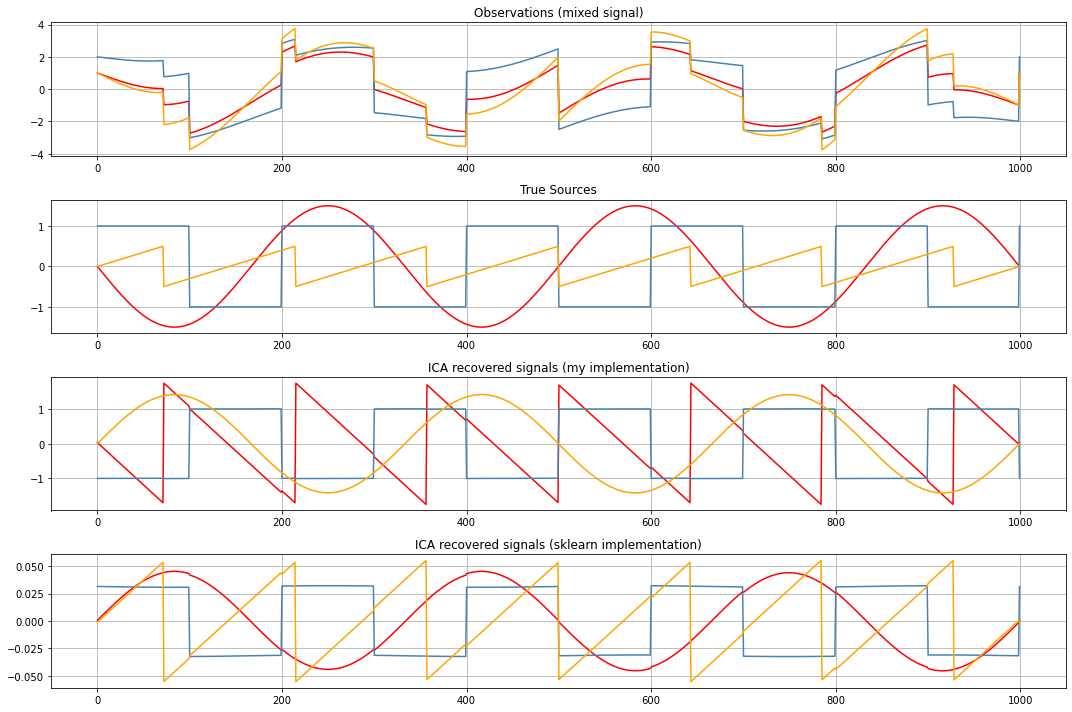

In [7]:
plt.figure(figsize=(15, 10))

models = [X, S, my_S, sk_S]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals (my implementation)',
         'ICA recovered signals (sklearn implementation)']
colors = ['red', 'steelblue', 'orange']
plots = len(models)

for ii, (model, name) in enumerate(zip(models, names)):
    plt.subplot(plots, 1, ii + 1)
    plt.title(name)
    plt.plot(model[0], color=colors[0])
    plt.plot(model[1], color=colors[1])
    try:
        plt.plot(model[2], color=colors[2])
    except:
        pass
    plt.grid()
    
plt.tight_layout()
plt.show()

## 3. Deflation vs parallel
In the `fast_ica` implementation, there are two strategies:

- deflation, which computes each unit sequentially and accumulates the error;
- parallel, which computes each unit in parallel and averages the error.

Let's compare the execution time of both.

In [8]:
%%timeit -n 1000 -r 3

fast_ica(X, n_components=3, strategy="deflation")

734 µs ± 35.5 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


In [9]:
%%timeit -n 1000 -r 3

fast_ica(X, n_components=3, strategy="parallel")

758 µs ± 9.8 µs per loop (mean ± std. dev. of 3 runs, 1000 loops each)


As it can be seen, the parallel version has comparable performances. However, when the number of components increases, the performance gap should also increase.

Let's now plot both the results of the deflation and parallel implementations.

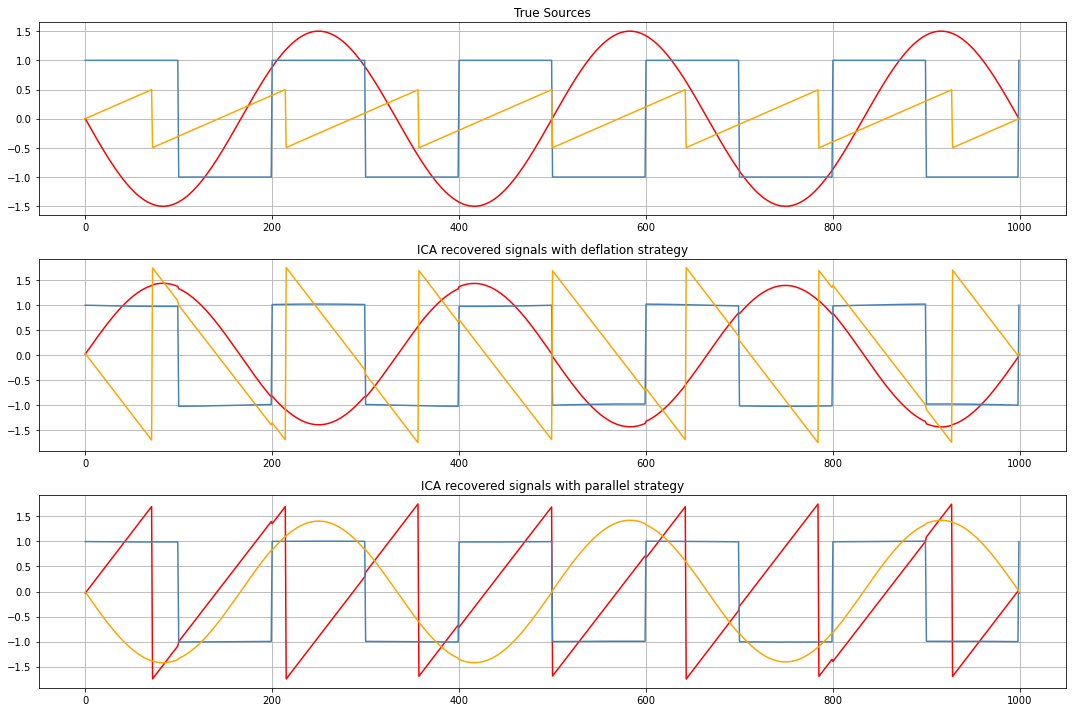

In [10]:
S_def = fast_ica(X, n_components=3, strategy="deflation")
S_sym = fast_ica(X, n_components=3, strategy="parallel")

plt.figure(figsize=(15, 10))

models = [S, S_def, S_sym]
names = ['True Sources',
         'ICA recovered signals with deflation strategy',
         'ICA recovered signals with parallel strategy']
colors = ['red', 'steelblue', 'orange']
plots = len(models)

for ii, (model, name) in enumerate(zip(models, names)):
    plt.subplot(plots, 1, ii + 1)
    plt.title(name)
    plt.plot(model[0], color=colors[0])
    plt.plot(model[1], color=colors[1])
    plt.plot(model[2], color=colors[2])
    plt.grid()
    
plt.tight_layout()
plt.show()

## 4. Test with real data
Now we will test the algorithm on real fMRI data. First of all, we need to download the dataset.

In [11]:
# Download dataset
dataset = datasets.fetch_development_fmri(n_subjects=1)  # use only one subject
func_filename = dataset.func[0]

print(f"First subject functional nifti image (4D) is at: {dataset.func[0]}")

First subject functional nifti image (4D) is at: /home/nihil/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


Then, we preprocess data to remove background.

In [12]:
masker = NiftiMasker(smoothing_fwhm=8, memory="nilearn_cache", memory_level=1, mask_strategy="epi", standardize=True)
data_masked = masker.fit_transform(func_filename)
data_masked.shape

(168, 24256)

We can now apply the FastICA algorithm.

In [13]:
%%timeit -n 10 -r 3

fast_ica(data_masked, n_components=20, strategy="deflation", max_iter=200)

2.62 s ± 31.4 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [14]:
%%timeit -n 10 -r 3

fast_ica(data_masked, n_components=20, strategy="parallel", max_iter=200)

1.16 s ± 39.4 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


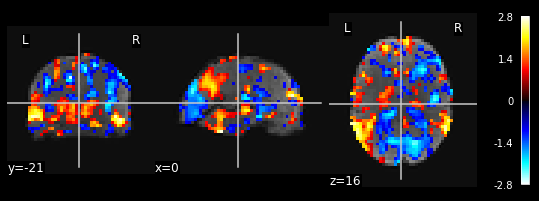

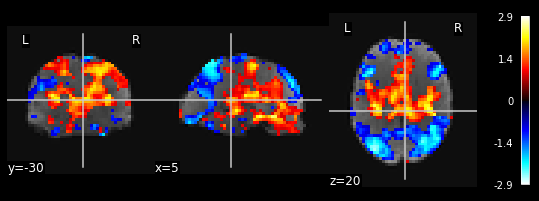

In [15]:
components_masked = fast_ica(data_masked, n_components=10, strategy="parallel", max_iter=200)

# Normalize estimated components
components_masked -= components_masked.mean(axis=0)
components_masked /= components_masked.std(axis=0)
# Apply threshold
components_masked[np.abs(components_masked) < .8] = 0

# Now invert the masking operation, going back to a full 3D representation
component_img = masker.inverse_transform(components_masked)

mean_img = image.mean_img(func_filename)
plot_stat_map(image.index_img(component_img, 0), mean_img)
plot_stat_map(image.index_img(component_img, 1), mean_img)
show()